In [1]:
import tensorflow as tf
import numpy as np
# Tensorflow Dist
import tensorflow_probability as tfp
tfd = tfp.distributions

from collections import deque # Used to have limited arrays

import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

import os
import re   #regex
import time
import datetime
#import json
#import gc # Garbage collector of Python


from datetime import datetime
from google.colab import drive
# Libs for Images
from PIL import Image
import imageio

import glob #it does pattern matching and expansion <- Retrieving filenames on system and such
#from tensorflow.keras.preprocessing.image import ImageDataGenerator


#import itertools
#from sklearn.metrics import confusion_matrix , classification_report

# Manipulate the cells output
from IPython import display

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"



# Set the seed for random operations. 
# This let our experiments to be reproducible. 
SEED = 1234
tf.random.set_seed(SEED) 
# Easy life 
tensorboard_loaded = False


#Google Drive
drive.mount('/content/drive')

base_path = '/content/drive/My Drive/'
path_to_TrackGAN = base_path + 'Colab Notebooks/TrackGAN/'

# Reloading Custom Libraries
import importlib
# Custom Libraries Path
import sys
sys.path.append(base_path + 'Libs')

# Custom Libraries Import
import keras_utils
import keras_models
import image_utils
import train_asses

Mounted at /content/drive


In [2]:
def rlib():
  libs = [keras_utils , keras_models , image_utils, train_asses]
  for lib in libs:
    importlib.reload(lib)

In [3]:
#cwd = os.getcwd()

from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

X_ = np.concatenate((x_train, x_test), axis=0)
Y_ = np.concatenate((y_train, y_test), axis=0)

X_ = X_.reshape(X_.shape[0], 28, 28, 1).astype('float32')

X_.shape
print()
Y_.shape

11501568/11490434 [==============================] - 0s 0us/step


(70000, 28, 28)

(70000,)

In [5]:
BATCH_SIZE = 128
BUFFER_SIZE = 60000

training_dataset = tf.data.Dataset.from_tensor_slices((X_[:60000],Y_[:60000]))
# Normalize
training_dataset = training_dataset.map(image_utils.normalize_image)
# To One Hot
training_dataset = training_dataset.map(train_asses.to_one_hot_encode)
# Batch and shuffle the data
training_dataset = training_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE,drop_remainder=True) # In Order to have the same batch Dimension, without a repeat dataset - To change  


valid_dataset = tf.data.Dataset.from_tensor_slices((X_[-BATCH_SIZE:],Y_[-BATCH_SIZE:]))
# Normalize
valid_dataset = valid_dataset.map(image_utils.normalize_image)
# To One Hot
valid_dataset = valid_dataset.map(train_asses.to_one_hot_encode)
# To Batch
valid_dataset = valid_dataset.batch(BATCH_SIZE)


training_dataset
print()
valid_dataset

<BatchDataset shapes: ((128, 28, 28, 1), (128, 10)), types: (tf.float32, tf.float32)>

<BatchDataset shapes: ((None, 28, 28, 1), (None, 10)), types: (tf.float32, tf.float32)>

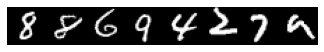

In [ ]:
for x,y in training_dataset:
  image_utils.display_multiple_image(x[:8] , size=[400,600] , denormalize=True)
  break

In [6]:
rlib()
epsilon = 1e-3

# Original Data
mean_per_px , std_per_px = image_utils.get_mean_std_per_pixel(X_)
mean_per_channel , std_per_channel = image_utils.get_mean_std_per_channel(X_)

mean_per_patch_channel , std_per_patch_channel = image_utils.get_mean_std_per_patch(X_ , patch_shape  = [2,2] , patch_type = 'channel' )


px_dist = tfd.Normal(loc=mean_per_px+epsilon, scale=std_per_px+epsilon)
ch_px_dist = tfd.Normal(loc=mean_per_channel+epsilon, scale=std_per_channel+epsilon)
patch_ch_px_dist = tfd.Normal(loc=mean_per_patch_channel+epsilon, scale=std_per_patch_channel+epsilon)

In [7]:
distributions = {"Distribution per Pixel" : px_dist , "Distribution Per Channel" : ch_px_dist , "Distribution Per (2,2) Patch" :  patch_ch_px_dist}
distributions

In [ ]:
rlib()
image_utils.plot_channels_dist(ch_px_dist )

In [ ]:
rlib()
keras_models.make_conditioned_generator_model().summary()
keras_models.make_conditioned_discriminator_model().summary()

**Discriminator loss**

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.


**Generator loss**

The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s.

In [10]:
rlib()
discriminator_loss = train_asses.discriminator_BinaryCrossentropy_loss
generator_loss = train_asses.generator_BinaryCrossentropy_loss

In [11]:
generator = keras_models.make_conditioned_generator_model()
discriminator = keras_models.make_conditioned_discriminator_model()

model_name = 'ConditionedGAN G 356k-275k'

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)


lr_dcgan = 0.0002
beta1_dcgan = 0.5
#1e-4
generator_optimizer = tf.keras.optimizers.Adam(lr_dcgan,beta_1=beta1_dcgan)
discriminator_optimizer = tf.keras.optimizers.Adam(lr_dcgan, beta_1=beta1_dcgan)

#generator_optimizer = tf.keras.optimizers.Adam(learning_rate = 5e-4)
#discriminator_optimizer = tf.keras.optimizers.SGD(learning_rate = 5e-4, momentum = 0.9)

#discriminator_optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule )


checkpoint_dir = path_to_TrackGAN + 'training_checkpoints/' + model_name
checkpoint = tf.train.Checkpoint(step=tf.Variable(1),
                                 generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


# Limit Number of checkpoints and Manage restoring
checkpoint_manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep = 5 , checkpoint_name= 'tf_ckpts')


# Maybe this is the issue with tensorboard
try:
  summary_writer.close()
except: pass

# NO IDEA

# tensorboard summary
log_dir = path_to_TrackGAN + "logs/" + "fit/" + model_name 
log_dir
summary_writer = tf.summary.create_file_writer(log_dir)
summary_writer.init()

'/content/drive/My Drive/Colab Notebooks/TrackGAN/logs/fit/ConditionedGAN G 356k-275k'

In [12]:
noise_dim = 100
num_examples_to_generate = 36

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
target_seed = np.array([ [1,0,0,0,0,0,0,0,0,0] ]*num_examples_to_generate) 
target_seed = []

for i in range(9):
  sample_target = [0,0,0,0,0,0,0,0,0,0]
  sample_target[i] = 1
  #print(sample_target)

  #test_target = np.array([ sample_target ]*num_examples_to_generate)
  for _ in range(0,4):
    target_seed.append( sample_target )


seed_save_path = base_path + 'DATA_Rep/36cond_seed_mnist-28x28.npy'
noise_seed = train_asses.get_seed(shape = [num_examples_to_generate , noise_dim] , seed_save_path = seed_save_path )

target_seed = np.array(target_seed)
print(target_seed.shape)
noise_seed.shape

Restoring seed from /content/drive/My Drive/DATA_Rep/36cond_seed_mnist-28x28.npy
(36, 10)


(36, 100)

In [ ]:
# This cell is useful if you want to visualize Tensorboard in your Colab notebook. 
# Please run the cell before training, otherwise you have to wait the training cell is completed before running this one.  

# If you are using jupyter notebook, you can skip this cell and open Tensorboard with the following:
# From terminal: tensorboard --logdir /PATH/TO/YOUR/EXPERIMENTS/ --port PORT
# Go to 127.0.0.1:PORT in your web browser

%load_ext tensorboard
#%reload_ext tensorboard
%tensorboard --logdir /content/drive/My\ Drive/Colab\ Notebooks/classification_experiments_/ --port 6011
#tensorboard --logdir log_dir --port 6010

Things to look for:
- Check that neither the generator nor the discriminator model has "won". If either the gen_gan_loss or the disc_loss gets very low, it's an indicator that this model is dominating the other, and you are not successfully training the combined model.
- The value log(2) = 0.69 is a good reference point for these losses, as it indicates a perplexity of 2 - the discriminator is, on average, equally uncertain about the two options.
- For the disc_loss, a value below 0.69 means the discriminator is doing better than random on the combined set of real and generated images.
- For the gen_gan_loss, a value below 0.69 means the generator is doing better than random at fooling the discriminator.

Saved checkpoint for step 42: /content/drive/My Drive/Colab Notebooks/TrackGAN/training_checkpoints/ConditionedGAN G 356k-275k/tf_ckpts-43

Generator Epoch loss 3.368
Discriminator Epoch Total Loss 0.519  Discriminator Epoch Real Loss 0.256  Discriminator Epoch Fake Loss 0.262

Avg Log Loss Distribution per Pixel : 7.16100201030216e+18
Avg Log Loss Distribution Per Channel : 452670.9387755102
Avg Log Loss Distribution Per (2,2) Patch : 121059.05102040817


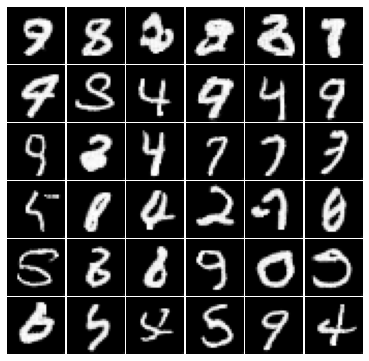

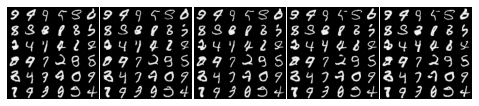

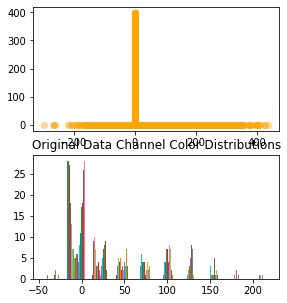

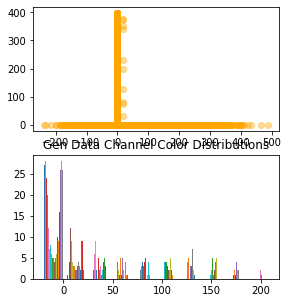

Time for epoch 42 is 625.5194187164307 sec
Epoch 43 : [59:468] <-      >
Epoch 43 : [119:468] <--     >
Epoch 43 : [179:468] <---    >


KeyboardInterrupt: ignored

In [14]:
# With random weights initialization the accuracy on fake images is very high, due to low weights -> low weights output -> sigmoid -> 0 -> 0 is good for fake images.
# The discriminator won't learn how to classify real images, will just be resilient to the generaor -> from epoch 1 and on Accuracy on real images = 0
# Find measure of image quality - perhaps mean std per pixel in dataset and compute the probability of that

# Convert ln of loss in probability
# USE AVG/MAX POOLING for image smoothness

# Aggiungere grafico con le immagini generate e la probabilità assegnata dal dataset d'origine
# Fix the x axis of the graphs, otherwise thwy will look similar
# MODIFY ALSO DISCRIMINATOR
# Add avg pooling as last layer - to smooth images coming out of the generator

# The log loss when you have conditioning cannot be computed conditioned_image vs entire original dataset. It won't match
# LOG TO TENSORBOARD ALSO DISTRIBUTIONs DISPLAYED BY MATPLOT
# MATPLOT TITLE PER SUBPLOT
# CHECK DISTRIBUTION ON NORMALIZED OR NOT IMAGES
# CHANGE HOW TO GEN EXTRA INPUTS OR BATCH WITH DIFFERENT SIZE FUCK UP

# Save to tensorboard THE DISTO PLOTS!!
rlib()
EPOCHS = 50
#valid_dataset
image_save_path = path_to_TrackGAN + 'Generated Images/' + model_name +'/'




train_asses.train(training_dataset , EPOCHS , valid_dataset = None , starting_epoch = checkpoint.step.numpy() ,
                  generator = generator , discriminator=discriminator,generator_optimizer=generator_optimizer , discriminator_optimizer=discriminator_optimizer,
                  generator_loss = generator_loss , discriminator_loss=discriminator_loss , noise_dim = noise_dim, summary_writer= summary_writer, gen_seed = [noise_seed , target_seed ],
                  checkpoint_manager =checkpoint_manager,distributions = distributions, model_name = model_name, DEBUG = False , BATCH_SIZE = BATCH_SIZE , image_save_path = image_save_path )


'''
309148.

'''

In [13]:
#checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
if checkpoint_manager.latest_checkpoint:
  print("Restored from {}".format(checkpoint_manager.latest_checkpoint))
  _ = checkpoint.restore(checkpoint_manager.latest_checkpoint)
  #checkpoint_to_restore = '/content/drive/My Drive/Colab Notebooks/TrackGAN/training_checkpoints/ConditionedGAN Shrinked/tf_ckpts-146'
  #_ = checkpoint.restore(checkpoint_to_restore)



Restored from /content/drive/My Drive/Colab Notebooks/TrackGAN/training_checkpoints/ConditionedGAN G 356k-275k/tf_ckpts-22


[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]


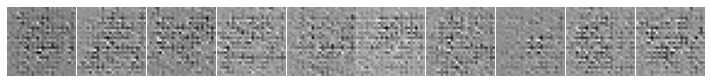

[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]


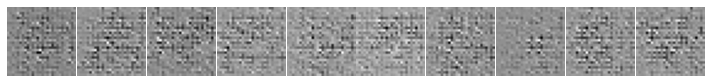

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]


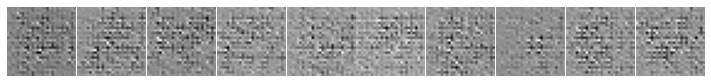

[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]


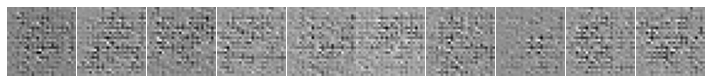

In [ ]:
noise_dim = 100
num_examples_to_generate = 10

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
test_seed = tf.random.normal([num_examples_to_generate, noise_dim])

model_name = "Prediction CGAN"

for i in range(0,4):
  sample_target = [0,0,0,0,0,0,0,0,0,0]
  sample_target[i] = 1
  print(sample_target)

  test_target = np.array([ sample_target ]*num_examples_to_generate) 
  generated_images = generator([test_seed , test_target],training= False)
  image_utils.display_multiple_image(image_utils.denormalize_images(generated_images) ,  size = (900,900), inline=True)


In [ ]:
image_path = path_to_TrackGAN + 'Generated Images/' + model_name +'/'

anim_file = path_to_TrackGAN + 'Generated Images/' + model_name + '.gif'

image_utils.generate_GIF(image_path, anim_file)

In [ ]:
#!pip install  git+https://github.com/tensorflow/docs
#import tensorflow_docs.vis.embed as embed

embed.embed_file(anim_file)